In [1]:
from datasets.display import show_detections
import datasets.pascal_voc as pascal
import matplotlib.pyplot as plt
from matplotlib import patches
from model import build_network
import numpy as np
import skimage
from skimage import io, transform
import tensorflow as tf

c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Check basic functionality in eager mode

In [2]:
tf.enable_eager_execution()

In [3]:
image_paths, annotation_paths = pascal.get_image_paths()

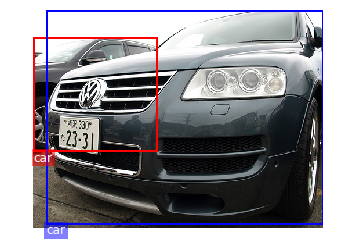

In [5]:
rand_idx = np.random.randint(0, len(image_paths))
image, class_ids, bboxes = pascal.load_image_data(image_paths[rand_idx], annotation_paths[rand_idx])
show_detections(image, bboxes, class_ids, pascal.PASCAL_CLASSES)

In [7]:
image_tens = tf.convert_to_tensor(image[None, :])
id_tens = tf.convert_to_tensor(class_ids[None, :])
box_tens = tf.convert_to_tensor(bboxes[None, :])
outputs = build_network(image_tens, id_tens, box_tens, {}, True, True)

In [10]:
roi_targets, roi_logits, roi_deltas = outputs['roi']
roi_target_classes, roi_target_deltas = outputs['roi_targets']

# Check estimator training

In [5]:
num_images = 100
max_num_obj = 0
all_images, all_ids, all_bboxes = [], [], []
for idx in range(num_images):
    this_image, this_ids, this_boxes = pascal.load_image_data(image_paths[idx], annotation_paths[idx])
    if this_image.shape != (375, 500, 3):
        continue
    all_images.append(this_image)
    all_ids.append(this_ids)
    all_bboxes.append(this_boxes)
    if this_ids.size>max_num_obj:
        max_num_obj = this_ids.size
        
all_ids = [np.pad(x, ((0, max_num_obj-x.size)), 'constant', constant_values=-1) for x in all_ids]
all_bboxes = [np.pad(x, ((0, max_num_obj-x.shape[0]), (0, 0)), 'constant') for x in all_bboxes]

images = np.stack(all_images, axis=0)
class_ids = np.stack(all_ids, axis=0)
bboxes = np.stack(all_bboxes, axis=0)

In [6]:
images = images-np.mean(images,axis=0)

In [10]:
from model import model_fn
estimator = tf.estimator.Estimator(model_fn, model_dir='logs/test', 
                                   params={'backbone_ckpt': './resnet_v2_imagenet_checkpoint/model.ckpt-250200'}, 
                                   config=tf.estimator.RunConfig(keep_checkpoint_max=1))

INFO:tensorflow:Using config: {'_model_dir': 'logs/test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000F3BC630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [9]:
input_fn = tf.estimator.inputs.numpy_input_fn(images, y={'classes': class_ids, 'bboxes': bboxes}, shuffle=True, batch_size=1)

In [20]:
estimator.train(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/gamma
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block/bn_1/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block/bn_2/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_1/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_2/ga

INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/beta
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/gamma
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_6/bn_2/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_19/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block/bn_3/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_2/beta
INFO:tensorflow:Initialize variable res_net/res_block/bn_3/gamma from check

INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/beta
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/gamma
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_9/bn_3/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_29/moving_variance
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_1/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_3/beta
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_1/gamma from c

INFO:tensorflow:Initialize variable res_net/res_block_1/bn_2/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_4/beta
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_2/gamma from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_4/gamma
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_2/moving_mean from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_4/moving_mean
INFO:tensorflow:Initialize variable res_net/res_block_1/bn_2/moving_variance from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_4/moving_variance
INFO:tensorflow:Initialize variable roi_head/time_distributed_3/bn_final/beta from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/batch_normalization_48/beta
INFO:tensorflow:Initialize variable roi_head/time_distributed_3/

INFO:tensorflow:Initialize variable res_net/res_block_7/conv_0/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_24/kernel
INFO:tensorflow:Initialize variable res_net/res_block_7/conv_1/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_25/kernel
INFO:tensorflow:Initialize variable res_net/res_block_7/conv_2/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_26/kernel
INFO:tensorflow:Initialize variable res_net/res_block_7/conv_3/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_27/kernel
INFO:tensorflow:Initialize variable res_net/res_block_8/conv_1/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resnet_model/conv2d_28/kernel
INFO:tensorflow:Initialize variable res_net/res_block_8/conv_2/kernel from checkpoint ./resnet_v2_imagenet_checkpoint/model.ckpt-250200 with resn

c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into logs/test\model.ckpt.
INFO:tensorflow:loss = 5.804205, step = 1


KeyboardInterrupt: 